In [1]:
import torch
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
import matplotlib.pyplot as plt
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import AnalyticSource

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

DEVICE='cuda'

In [2]:
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN

### Array Source

In [3]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])


In [4]:
# Lens param
x = -0.05
y = 0.1
phi = 1.
q = 0.5
r_ein = 1.4
slope = 2.1

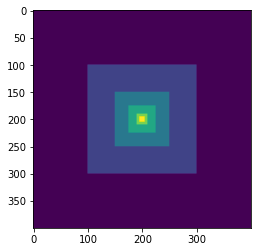

In [5]:
# Source image
src_image = torch.rand([400,400])*0
src_image[100:300,100:300] += 1
src_image[150:250,150:250] += 1
src_image[175:225,175:225] += 1
src_image[190:210,190:210] += 1
src_image[195:205,195:205] += 1
plt.imshow(src_image.cpu())

In [6]:
def deproject(image, X, Y, Xsrc, Ysrc):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        N = 2
        idx = unravel_index(kNN(P, Psrc, N).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (400, 400, N, 2))
        src_image = [image[idx[..., i,0], idx[..., i,1]] for i in range(N)]
        src_image = sum(src_image)/N
        return src_image

In [7]:
def model(x, y, phi, q, r_ein, slope, src_image):

    res = 0.0125                        # resolution in arcsec
    nx, ny = 400, 400                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 5)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

<ipython-input-3-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


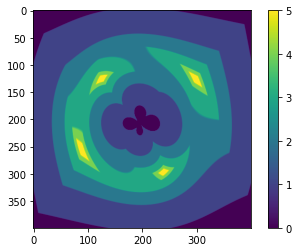

In [10]:
image, coords = model(x, y, phi, q, r_ein*1.05, slope, src_image)
plt.imshow(image.cpu());
plt.colorbar()

In [11]:
image2 = deproject(image, coords[0], coords[1], coords[2], coords[3])

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


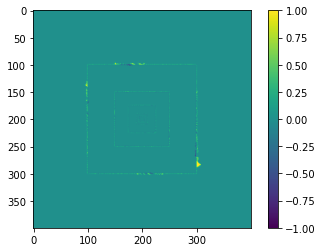

In [12]:
plt.imshow(image2.cpu() - src_image.cpu())
plt.colorbar()